Original: https://www.kaggle.com/code/shubhamsanu/prediction-using-xgboost-with-r2-score-0-88

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/housesalesprediction/kc_house_data.csv


In [2]:
data =pd.read_csv("../input/housesalesprediction/kc_house_data.csv")

In [3]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
pd.set_option('display.max_columns', None)

In [6]:
data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [7]:
data.info() # Yeah, except for date every column is int / float type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [8]:
# Lets first check missing values
data.isna().sum() # No missing values, good!!!

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [9]:
# Lets look at our target varibale

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

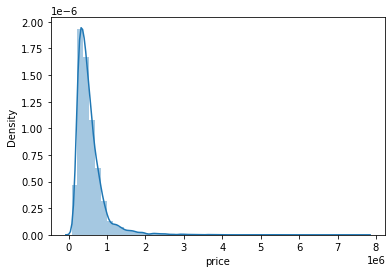

In [10]:
sns.distplot(data.price) # seems like there is some outlier and skewed towards right

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='price'>

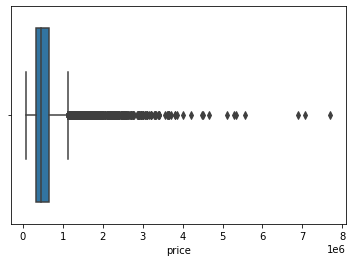

In [11]:
sns.boxplot(data.price) # Lets drop the value over 1.25

In [12]:
data.shape

(21613, 21)

In [13]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [14]:
data.price.describe()

count    2.161300e+04
mean     5.400881e+05
std      3.671272e+05
min      7.500000e+04
25%      3.219500e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

In [15]:
(data.price > 1250000).sum()

870

In [16]:
df0 = data.copy()

In [17]:
df0 = df0[~(data.price > 1250000)]
df0 = df0.reset_index(drop=True)

In [18]:
df0.shape

(20743, 21)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

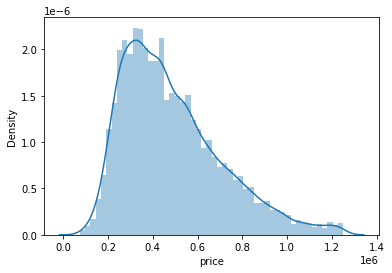

In [19]:
# Lets again look at distribution plot
sns.distplot(df0.price) # Close to normal distribution

In [20]:
# Drpping id column
df0.drop('id', axis =1, inplace = True)

In [21]:
# Lets solve this date column, it is giving me headache
df0[['date']]

,date
0,20141013T000000
1,20141209T000000
2,20150225T000000
3,20141209T000000
4,20150218T000000
...,...
20738,20140521T000000
20739,20150223T000000
20740,20140623T000000
20741,20150116T000000


In [22]:
# Going through the data, date is in yyyymmdd format

In [23]:
date_clm1 = pd.Series(v[0:8] for v in df0['date']) 

In [24]:
df0['Date_new'] = date_clm1

In [25]:
df1 = df0.copy()

In [26]:
df1.isna().sum()

date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
Date_new         0
dtype: int64

In [27]:
df1.drop('date', axis =1 , inplace = True)

In [28]:
# Convert to date object
df1['Date'] = pd.to_datetime(df1['Date_new'])

In [29]:
df1['year'] = pd.DatetimeIndex(df1['Date']).year
df1['month'] = pd.DatetimeIndex(df1['Date']).month

In [30]:
# Lets remove Date and Date_new column
df1.drop('Date_new', axis =1 , inplace = True)
df1.drop('Date', axis =1 , inplace = True)

In [31]:
df1.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,2014,10
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,2014,12
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,2015,2
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,2014,12
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,2015,2


In [32]:
df1.year.unique()

array([2014, 2015])

In [33]:
df1.month.unique()

array([10, 12,  2,  5,  6,  1,  4,  3,  7, 11,  8,  9])

In [34]:
df1.isna().sum()

price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
year             0
month            0
dtype: int64

In [35]:
df2 = df1.copy()

<AxesSubplot:xlabel='year', ylabel='price'>

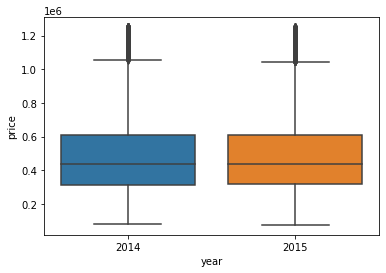

In [36]:
sns.boxplot(data = df2, x = 'year', y = 'price') # Lol, no difference, lets drop it or use to ctreate an ew feature

<AxesSubplot:xlabel='month', ylabel='price'>

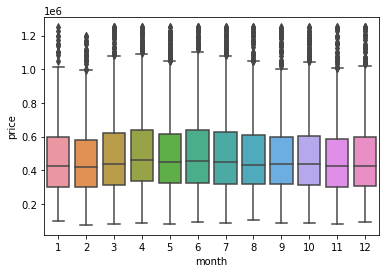

In [37]:
sns.boxplot(data = df2, x = 'month', y = 'price') # Lol, again, not much difference, lets drop it

In [38]:
df2.drop('month', axis =1, inplace = True)

In [39]:
df2.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'year'],
      dtype='object')

In [40]:
for col in df2.columns:
    print(col, ":" ,len(df2[col].unique()))

price : 3623
bedrooms : 13
bathrooms : 27
sqft_living : 919
sqft_lot : 9398
floors : 6
waterfront : 2
view : 5
condition : 5
grade : 11
sqft_above : 855
sqft_basement : 274
yr_built : 116
yr_renovated : 70
zipcode : 70
lat : 5024
long : 750
sqft_living15 : 738
sqft_lot15 : 8303
year : 2


<AxesSubplot:xlabel='waterfront', ylabel='price'>

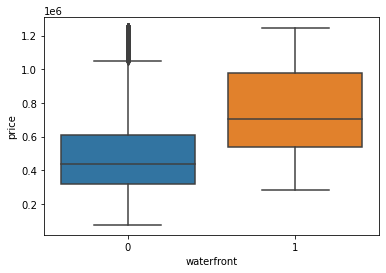

In [41]:
sns.boxplot(data = df2, x = 'waterfront', y = 'price') # Wow, there is clearly a difference

<AxesSubplot:xlabel='view', ylabel='price'>

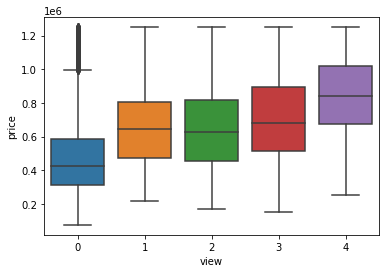

In [42]:
sns.boxplot(data = df2, x = 'view', y = 'price') # Wow, there is clearly a difference

<AxesSubplot:xlabel='floors', ylabel='price'>

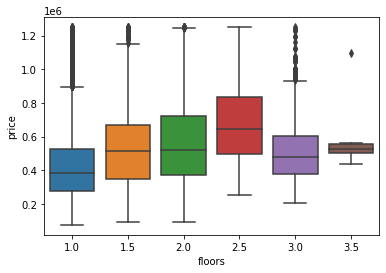

In [43]:
sns.boxplot(data = df2, x = 'floors', y = 'price') # We can remove or one hot encode it

<AxesSubplot:xlabel='condition', ylabel='price'>

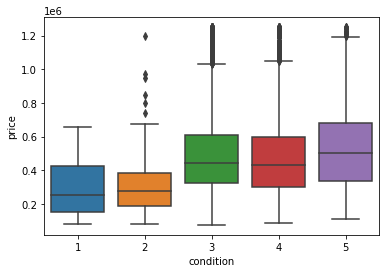

In [44]:
sns.boxplot(data = df2, x = 'condition', y = 'price') # Not a significant diff, lets take a call at last

In [45]:
corrmat = df2.corr()
corrmat

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year
price,1.000000,0.303677,0.468882,0.638678,0.093441,0.277134,0.070094,0.267828,0.035666,0.647513,0.545378,0.250213,0.062192,0.091878,-0.022373,0.416982,0.066366,0.578996,0.083225,-0.001022
bedrooms,0.303677,1.000000,0.498663,0.584503,0.026725,0.157201,-0.035235,0.044143,0.025915,0.329367,0.466231,0.287959,0.160283,0.005060,-0.147961,-0.024003,0.137780,0.374446,0.023190,-0.010212
bathrooms,0.468882,0.498663,1.000000,0.722873,0.068877,0.501070,-0.003787,0.107154,-0.136388,0.622330,0.645526,0.232539,0.538653,0.028184,-0.204970,-0.001208,0.246060,0.535268,0.068678,-0.030223
sqft_living,0.638678,0.584503,0.722873,1.000000,0.162368,0.343446,0.002601,0.185293,-0.073260,0.717536,0.857432,0.385466,0.351273,0.023423,-0.202942,0.020844,0.282526,0.743084,0.174438,-0.034506
sqft_lot,0.093441,0.026725,0.068877,0.162368,1.000000,-0.015889,0.024219,0.073389,-0.004077,0.096620,0.167252,0.012322,0.044859,0.010455,-0.130278,-0.093441,0.223601,0.143748,0.711285,-0.000419
floors,0.277134,0.157201,0.501070,0.343446,-0.015889,1.000000,-0.000869,-0.007756,-0.274874,0.456168,0.528356,-0.286971,0.506752,0.000663,-0.063224,0.039618,0.133670,0.269745,-0.020473,-0.022226
waterfront,0.070094,-0.035235,-0.003787,0.002601,0.024219,-0.000869,1.000000,0.307366,0.014861,-0.008547,-0.005753,0.015317,-0.041761,0.077436,0.045978,-0.042068,-0.058497,0.010825,0.031587,-0.007362
view,0.267828,0.044143,0.107154,0.185293,0.073389,-0.007756,0.307366,1.000000,0.035812,0.151314,0.080400,0.212140,-0.065008,0.074936,0.098578,-0.020788,-0.075764,0.203797,0.070757,-0.000263
condition,0.035666,0.025915,-0.136388,-0.073260,-0.004077,-0.274874,0.014861,0.035812,1.000000,-0.165734,-0.176594,0.175778,-0.354746,-0.058803,-0.004391,-0.017940,-0.101973,-0.115869,0.000430,-0.045407
grade,0.647513,0.329367,0.622330,0.717536,0.096620,0.456168,-0.008547,0.151314,-0.165734,1.000000,0.718476,0.091471,0.484748,-0.016433,-0.184299,0.092570,0.227943,0.681688,0.104566,-0.037960


<AxesSubplot:>

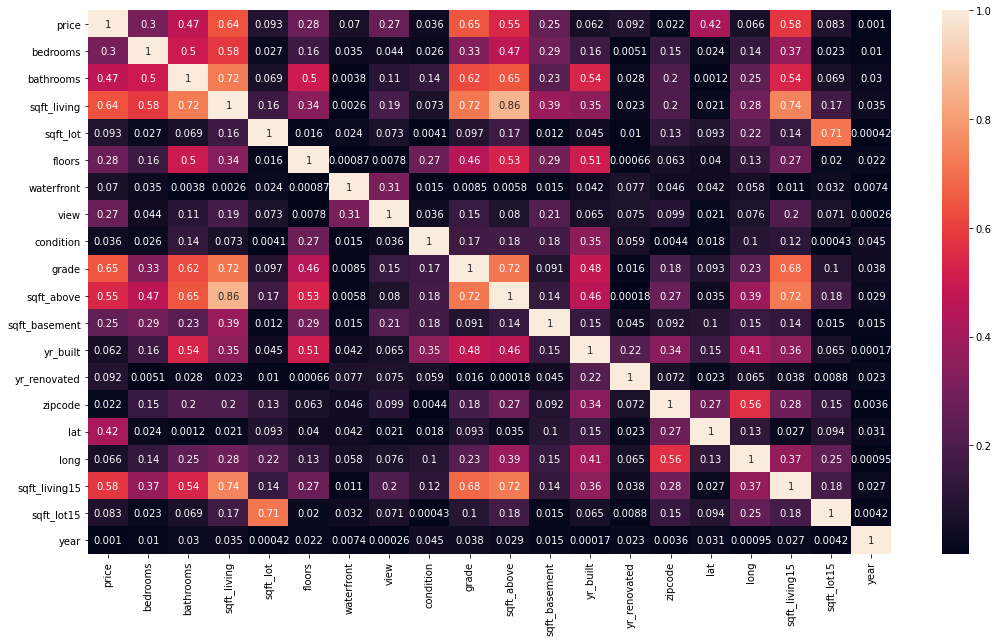

In [46]:
fig, ax = plt.subplots(figsize=(18,10))
sns.heatmap(corrmat.abs(), annot = True)

In [47]:
df3 = df2.copy()

In [48]:
df3 = df2.copy()

In [49]:
from sklearn.preprocessing import StandardScaler

In [50]:
X = df3.drop('price', axis = 1)
y = df3['price']

In [51]:
scaler = StandardScaler()

In [52]:
X_s = scaler.fit_transform(X)
X_s

array([[-0.36959179, -1.47806312, -1.02333333, ..., -0.94615555,
        -0.25829499, -0.68943459],
       [-0.36959179,  0.25915475,  0.72038531, ..., -0.39129485,
        -0.18338421, -0.68943459],
       [-1.46121112, -1.47806312, -1.5376676 , ...,  1.24158091,
        -0.16745295,  1.45046392],
       ...,
       [-1.46121112, -1.82550669, -1.22404914, ..., -1.45345676,
        -0.39549961, -0.68943459],
       [-0.36959179,  0.60659832, -0.49645432, ..., -0.83518341,
        -0.42261664,  1.45046392],
       [-1.46121112, -1.82550669, -1.22404914, ..., -1.45345676,
        -0.41998026, -0.68943459]])

In [53]:
from sklearn.model_selection import train_test_split

In [54]:
X1_train, X1_test, y_train, y_test = train_test_split(X_s,y, test_size =0.3)

In [55]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [56]:
model = LinearRegression()
model.fit(X1_train,y_train)

LinearRegression()

In [57]:
y_predict = model.predict(X1_test)

In [58]:
from sklearn.metrics import r2_score

In [59]:
score = r2_score(y_test,y_predict)
score

0.7048827553021412

In [60]:
import xgboost as xgb

In [61]:
xgb = xgb.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

In [62]:
xgb.fit(X1_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.08, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.75,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [63]:
xgb.fit(X1_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.08, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.75,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [64]:
predictions = xgb.predict(X1_test)
score1 = r2_score(y_test,predictions)

In [65]:
score1

0.879374467148369

In [66]:
# Lets do cross-validation

In [67]:
from sklearn.model_selection import cross_val_score

In [68]:
cross_val_score(xgb, X_s,y, cv =30).mean()

0.8807825587786046

In [69]:
# Thank you, long live Kaggle!